In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import f1_score
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from logistic_regression import logistic
from scipy.stats.mstats import mquantiles
import seaborn as sns
import scipy.stats

In [2]:
sns.set_theme(style="white", palette="pastel")

In [3]:
def log_reg_fit(X, y):
    X = X.reshape(-1, 1)
#     X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 99)
    model = LogisticRegression()
    model.fit(X, y)
#     print(model.score(X_test,y_test))
#     y_prediction = model.predict(X_test)
#     print('f1', f1_score(y_test, y_prediction))
#     print('50%', -(model.intercept_)/model.coef_[0,0])
#     print(model.coef_, model.intercept_)
    return 0 , model.coef_[0], model.intercept_

In [4]:
def lin_reg(X, y):
    X = X.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    reg.fit(X, y)
    print(reg.coef_, reg.intercept_)

In [5]:
def find_frequency(row, second_str, WORD, freq_dict):
    not_found = 0
    num_2_key = ""
    num_2_frequency = 0
    min_val = min(str(row['testcase.data_point.frequency_data.x']), str(row[f'testcase.data_point.frequency_data.{second_str}']))
    max_val = max(str(row['testcase.data_point.frequency_data.x']), str(row[f'testcase.data_point.frequency_data.{second_str}']))
    if WORD in ['mult', 'plus']:
        tuple1 = (min_val, max_val)
        tuple2 = (max_val, min_val)
    else:
        tuple1 = (min_val, max_val, WORD)
        tuple2 = (max_val, min_val, WORD)
    if tuple1 in freq_dict.keys() and tuple2 in freq_dict.keys() and not (tuple1 == tuple2):
            print(f"something is very wrong!!!!!!!!!!! tuple1: {tuple1} tuple2: {tuple2}")
    if tuple1 in freq_dict.keys():
        num_2_key = str(tuple1)
        num_2_frequency = freq_dict[tuple1]
    elif tuple2 in freq_dict.keys():
        num_2_key = str(tuple2)
        num_2_frequency = freq_dict[tuple2]
    else:
        num_2_key = str(tuple1)
        not_found = 1
    return num_2_key, num_2_frequency, not_found

In [6]:
def quantile_accuracies_plot(x, y, q_num):
    frequencies = x
    is_correct = y
    # Quantiles computes the bin edges
    quantiles = np.quantile(x, q=np.linspace(0, 1, num=q_num+1))
    quantiles[-1] += 1  # Edge case, we don't want biggest freq to be in its own bin
    widths = quantiles[1:] - quantiles[:-1]
    
    # Digitize assigns each frequency to it's bin
    frequency_bins = np.digitize(frequencies, bins=quantiles)
    # Compute the mean and error bars of is_correct in each bin
    accuracies = np.zeros(shape=(quantiles.shape[0] - 1,))  # -1 since there is 1 less bin than endpoints
    h = np.zeros(shape=(quantiles.shape[0] - 1,))
    for bin_id in range(frequency_bins.min(), frequency_bins.max() + 1):
        data_to_bin = is_correct[frequency_bins == bin_id]
        accuracies[bin_id - 1] = np.mean(data_to_bin)
        n = len(data_to_bin)
        se = scipy.stats.sem(data_to_bin)
        h[bin_id - 1] = se * scipy.stats.t.ppf((1 + 0.95) / 2., n-1)
    #this is for finding the mid point for error bars
    mid_quantiles = np.sqrt(quantiles[:-1]*quantiles[1:])
    return quantiles, accuracies, widths ,h, mid_quantiles

In [7]:
def create_plots_and_metrics(WORD, MODEL, SHOTS):
    ret_dict = {}
    #Just frequency of x:
    FREQ_NUM=1
    WORD_FLAG = False
    TOP_FREQ = 200

    if WORD in ['mult', 'plus', 'concat', 'plushashtag', 'multhashtag']:
        file_name = f'./results2/results/num{FREQ_NUM}_{WORD}_1to50_top{TOP_FREQ}_{MODEL}_{SHOTS}shots_5seeds_results.csv'
    elif WORD in ['compareless', 'comparemore']:
        file_name = f'./results2/results/num{FREQ_NUM}_{WORD}_1to100_top{TOP_FREQ}_{MODEL}_{SHOTS}shots_5seeds_results.csv'
    else:
        file_name = f'./results2/results/num{FREQ_NUM}_{WORD}_top{TOP_FREQ}_{MODEL}_{SHOTS}shots_5seeds_results.csv'
    data_file = pd.read_csv(file_name)
    data_file.replace(True, 1, inplace=True)
    data_file.replace(False,0, inplace=True)

    aggregated_by_key = data_file.groupby('testcase.data_point.frequency_data.key')['is_correct', 'testcase.data_point.frequency_data.frequency'].mean()
    # aggregated_by_key.plot(kind='scatter', x='testcase.data_point.frequency_data.frequency', y='is_correct')
    spearman_correlation = aggregated_by_key.corr(method='spearman')
    sp_corr = spearman_correlation.loc['is_correct', 'testcase.data_point.frequency_data.frequency']
    ret_dict['spearman_correlation'] = sp_corr
    
    frequencies = aggregated_by_key['testcase.data_point.frequency_data.frequency'].to_numpy()
    is_correct = aggregated_by_key['is_correct'].to_numpy()
    quantiles, accuracies, widths ,h, mid_quantiles = quantile_accuracies_plot(frequencies, is_correct, q_num=10)
    #plotting the bars
#     plt.xscale('log')
#     plt.bar(quantiles[:-1], height=accuracies, width=widths, align='edge', alpha=0.3, edgecolor='#182e52')
#     plt.errorbar(mid_quantiles, accuracies, yerr=h ,fmt="|", color="r" )
    quantile_bins = {}
    quantile_bins['quantiles'] = quantiles
    quantile_bins['accuracies'] = accuracies
    quantile_bins['widths'] = widths
    quantile_bins['h'] = h
    quantile_bins['mid_quantiles'] = mid_quantiles
    ret_dict['quantile_bining_params'] = quantile_bins
    
    #for fitting a logistic regression
    log_reg_fitted_params = {}
    freq_all = data_file['testcase.data_point.frequency_data.frequency'].to_numpy()
    accuracy_all = data_file['is_correct'].to_numpy()
    frequencies_log10 = np.log10(freq_all)
#     len_all = int(len(frequencies_log10)/5)
#     print(len_all)
#     coeffs = np.zeros(shape=(5,))  
#     inters = np.zeros(shape=(5,))
#     scores = np.zeros(shape=(5,))
#     for i in range(5):
#         s_division = i*len_all
#         e_division = (i+1)*len_all
#         print(s_division, e_division)
    mean_score, mean_coeff, mean_inter = log_reg_fit(frequencies_log10, accuracy_all)
    print(mean_coeff, mean_inter)
#     print(coeffs)
#     mean_coeff = np.mean(coeffs)
#     mean_coeff = np.mean(inters)
#     mean_score = np.mean(scores)
    log_reg_fitted_params['mean_coeff'] = mean_coeff
    log_reg_fitted_params['mean_inter'] = mean_inter
    log_reg_fitted_params['mean_score'] = mean_score
    t = np.linspace(frequencies_log10.min(), frequencies_log10.max(), 10000)[:, None]
    p_t = logistic(t.T, -mean_coeff, -mean_inter)
    t = np.power(10, t)
    log_reg_fitted_params['t'] = t
    log_reg_fitted_params['p_t'] = p_t
    ret_dict['log_reg_fitted_params'] = log_reg_fitted_params
#     plt.plot(t[:,0], p_t[0,:], lw=1, ls="--", color="k",
#              label="average posterior \nprobability of correctness")
#     sns.regplot(data=aggregated_by_key, x='testcase.data_point.frequency_data.frequency', y='is_correct', scatter=True, fit_reg=False, scatter_kws={"color": "#18A558", "s":2}, x_jitter=0.01, y_jitter=0.01)
    scatter_params = {}
    scatter_params['data'] = aggregated_by_key
    scatter_params['x'] = 'testcase.data_point.frequency_data.frequency'
    scatter_params['y'] = 'is_correct'
    ret_dict['scatter_params'] = scatter_params
    return ret_dict

/home/yrazeghi/miniconda3/envs/GPTJ-proc/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


[1.01645938] [-9.70427438]


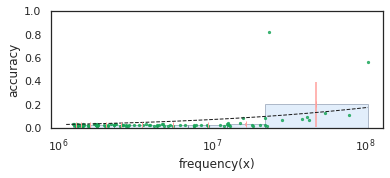

/home/yrazeghi/miniconda3/envs/GPTJ-proc/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


[1.95567521] [-13.55260934]


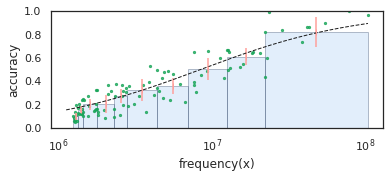

/home/yrazeghi/miniconda3/envs/GPTJ-proc/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


[1.71802921] [-11.84726113]


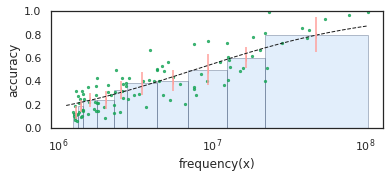

/home/yrazeghi/miniconda3/envs/GPTJ-proc/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


[1.87430923] [-12.78889852]


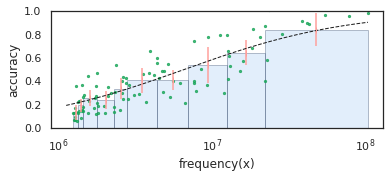

/home/yrazeghi/miniconda3/envs/GPTJ-proc/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


[2.1967097] [-14.96865598]


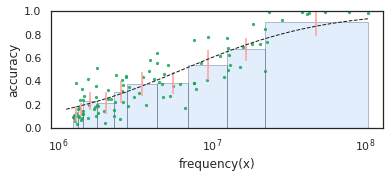

In [146]:
WORD = 'mult'
MODEL = 'gptj'
SHOTS = 2
FREQ_NUM=1
WORD_FLAG = False
TOP_FREQ = 200
for SHOTS in [0, 2, 4, 8, 20]:
    params_dic_1 = create_plots_and_metrics(WORD, MODEL, SHOTS)
    plt.xscale('log')
    quantile_bins = params_dic_1['quantile_bining_params']
    quantiles = quantile_bins['quantiles']
    accuracies = quantile_bins['accuracies']
    widths = quantile_bins['widths']
    h = quantile_bins['h']
    mid_quantiles = quantile_bins['mid_quantiles']
    plt.bar(quantiles[:-1], height=accuracies, width=widths, align='edge', alpha=0.3, edgecolor='#182e52')
    log_reg_fitted_params =params_dic_1['log_reg_fitted_params'] 
    mean_coeff = log_reg_fitted_params['mean_coeff'] 
    mean_inter = log_reg_fitted_params['mean_inter'] 
    mean_score = log_reg_fitted_params['mean_score']
    t = log_reg_fitted_params['t'] 
    p_t = log_reg_fitted_params['p_t']
    plt.errorbar(mid_quantiles, accuracies, yerr=h ,fmt="|", color="r" )
    plt.plot(t, p_t, lw=1, ls="--", color="k", label="")
    scatter_params = params_dic_1['scatter_params']
    x = scatter_params['x'] 
    y = scatter_params['y']
    data_params = scatter_params['data']
    sns.regplot(data=data_params, x=x, y=y, scatter=True, fit_reg=False, scatter_kws={"color": "#18A558", "s":5}, x_jitter=0.01, y_jitter=0.01)
    sp_corr = params_dic_1['spearman_correlation']

    # model_name_map = {
    #     'gptjsmall' : 'GPT-NEO-1.3B',
    #     'gptjlarge' : 'GPT-NEO-2.7B',
    #     'gptj' : 'GPT-J-6B'
    # }
    # model_name = model_name_map[MODEL]
    if MODEL == 'gptjsmall':
        model_name = 'GPT-NEO-1.3B'
    elif MODEL == 'gptjlarge':
        model_name = 'GPT-NEO-2.7B'
    elif MODEL == 'gptj':
        model_name = 'GPT-J-6B'
    if WORD == 'mult' and WORD_FLAG==False:
        MODE = 'Arithmetics-Multiplication'
    elif WORD == 'plus' and WORD_FLAG==False:
        MODE = 'Arithmetics-Adding'
    elif WORD == 'concat' and WORD_FLAG==False:
        MODE = 'Numbers-Concatination'
    elif WORD == 'mode10hashtag' and WORD_FLAG==False:
        MODE = 'Numbers-Mode10#'
    elif WORD == 'plushashtag' and WORD_FLAG==False:
        MODE = 'Numbers-Add#'
    elif WORD == 'multhashtag' and WORD_FLAG==False:
        MODE = 'Numbers-Mult#'
    elif WORD == 'compareless' and WORD_FLAG==False:
        MODE = 'Numbers-lower'
    elif WORD == 'comparemore' and WORD_FLAG==False:
        MODE = 'Numbers-higher'
    else:
        MODE = f'Time-Coversion-From{WORD}'
#     plt.title(f'mode:    {MODE}\n' 
#               f'shots:            {SHOTS}\n'
#               f'model:   {model_name}\n'
#               f'spearman corr:   {sp_corr:.2f}\n log-regression score: {mean_score:.2f} coef: {-mean_coeff[0,0]:.2f} intercept: {-mean_inter[0]:.2f} pr50: {(-mean_inter[0]/mean_coeff[0]):.2f}') #' \nlog_reg_intercept:  {-log_inter:.3f}\n', loc=left)
    plt.xlabel('frequency(x)')
    plt.ylabel('accuracy')
    plt.tight_layout()
    plt.subplots_adjust(top=0.60 )
    plt.subplots_adjust(right=0.90 )
    plt.ylim([0, 1])
    if SHOTS in [0, 2, 4, 8]:
        SHOTS = "0"+str(SHOTS)
    plt.savefig(f'./figures3/{MODE}_{SHOTS}shots_{model_name}.png', format='png', dpi=500)
    plt.show()

/home/yrazeghi/miniconda3/envs/GPTJ-proc/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/home/yrazeghi/miniconda3/envs/GPTJ-proc/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


[1.01645938] [-9.70427438]
[[1.13036200e+06]
 [1.13087272e+06]
 [1.13138367e+06]
 ...
 [1.03376338e+08]
 [1.03423045e+08]
 [1.03469774e+08]]
[0.15822506 0.15828246 0.15833989 ... 0.93318655 0.93321341 0.93324027]
[1.95567521] [-13.55260934]
[[1.13036200e+06]
 [1.13087272e+06]
 [1.13138367e+06]
 ...
 [1.03376338e+08]
 [1.03423045e+08]
 [1.03469774e+08]]
[0.02788393 0.02788934 0.02789474 ... 0.17394233 0.17397098 0.17399964]
[1.71802921] [-11.84726113]
[[1.13036200e+06]
 [1.13087272e+06]
 [1.13138367e+06]
 ...
 [1.03376338e+08]
 [1.03423045e+08]
 [1.03469774e+08]]
[0.1525833  0.15263292 0.15268255 ... 0.89292714 0.89296381 0.89300048]


/home/yrazeghi/miniconda3/envs/GPTJ-proc/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/home/yrazeghi/miniconda3/envs/GPTJ-proc/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


[1.87430923] [-12.78889852]
[[1.13036200e+06]
 [1.13087272e+06]
 [1.13138367e+06]
 ...
 [1.03376338e+08]
 [1.03423045e+08]
 [1.03469774e+08]]
[0.19036248 0.19041444 0.1904664  ... 0.87233329 0.87237082 0.87240834]


/home/yrazeghi/miniconda3/envs/GPTJ-proc/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


[2.1967097] [-14.96865598]
[[1.13036200e+06]
 [1.13087272e+06]
 [1.13138367e+06]
 ...
 [1.03376338e+08]
 [1.03423045e+08]
 [1.03469774e+08]]
[0.19103531 0.19109214 0.19114899 ... 0.90313948 0.90317164 0.9032038 ]


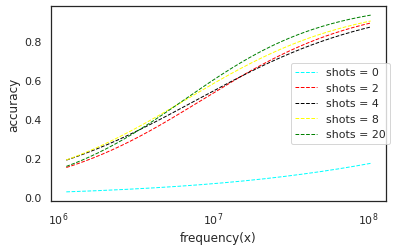

In [151]:
plt.xscale('log')
WORD = 'mult'
MODEL = 'gptj'
colors = ['cyan', 'red', 'black', 'yellow', 'green']
for i, shot in enumerate([0, 2, 4, 8, 20]):
    params_dic_1 = create_plots_and_metrics(WORD, MODEL, shot)
    log_reg_fitted_params =params_dic_1['log_reg_fitted_params'] 
    mean_coeff = log_reg_fitted_params['mean_coeff'] 
    mean_inter = log_reg_fitted_params['mean_inter'] 
    mean_score = log_reg_fitted_params['mean_score']
    t = log_reg_fitted_params['t'] 
    print(t)
    print(p_t)
    p_t = log_reg_fitted_params['p_t']
    plt.plot(t, p_t, lw=1, ls="--", color=colors[i], label=f"shots = {shot}" )
plt.legend(loc='center left', bbox_to_anchor=(0.70, 0.5))
# plt.title(f'mode:    {MODE}\n'
#               f'model:   {model_name}\n')
plt.xlabel('frequency(x)')
plt.ylabel('accuracy')
plt.subplots_adjust(top=0.80)
plt.subplots_adjust(right=0.90)
plt.savefig(f'./figures4/{MODE}_shots_{model_name}.pdf', format='pdf', dpi=500)



In [140]:
plt.xscale('log')
WORD = 'mult'
SHOT = 
colors = ['red', 'black', 'yellow', 'green']
for i, model in enumerate(['gptj', 'gptjsmall', 'gptjlarge']):
    params_dic_1 = create_plots_and_metrics(WORD, MODEL=model, SHOTS=SHOT)
    log_reg_fitted_params =params_dic_1['log_reg_fitted_params'] 
    mean_coeff = log_reg_fitted_params['mean_coeff'] 
    mean_inter = log_reg_fitted_params['mean_inter'] 
    mean_score = log_reg_fitted_params['mean_score']
    t = log_reg_fitted_params['t'] 
    p_t = log_reg_fitted_params['p_t']
    plt.plot(t[:,0], p_t[0,:], lw=1, ls="--", color=colors[i], label=f"model = {model} " )
plt.legend()
plt.savefig(f'./figures2/{MODE}_shots_{model_name}.png', format='png', dpi=500)

SyntaxError: invalid syntax (4073393264.py, line 3)

/home/yrazeghi/miniconda3/envs/GPTJ-proc/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


100
100
5098
0 5098
5098 10196
10196 15294
15294 20392
20392 25490
[1.6139811  1.1118515  1.32505553 0.73022784 0.42459632]


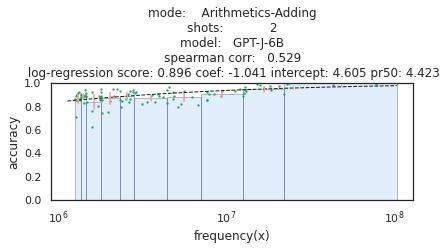

In [16]:
#Just frequency of x:
FREQ_NUM=1
WORD='plus' #mult, #plus or time_units #concat mode10# #plushashtag 'compareless'
WORD_FLAG = False
TOP_FREQ = 200
MODEL = 'gptj' #can be 'gptjsmall' 'gptjlarge'
SHOTS = 2 # 2

if WORD in ['mult', 'plus', 'concat', 'plushashtag']:
    file_name = f'./results2/results/num{FREQ_NUM}_{WORD}_1to50_top{TOP_FREQ}_{MODEL}_{SHOTS}shots_5seeds_results.csv'
elif WORD in ['compareless', 'comparemore']:
    file_name = f'./results2/results/num{FREQ_NUM}_{WORD}_1to100_top{TOP_FREQ}_{MODEL}_{SHOTS}shots_5seeds_results.csv'
else:
    file_name = f'./results2/results/num{FREQ_NUM}_{WORD}_top{TOP_FREQ}_{MODEL}_{SHOTS}shots_5seeds_results.csv'
data_file = pd.read_csv(file_name)
data_file.replace(True, 1, inplace=True)
data_file.replace(False,0, inplace=True)

aggregated_by_key = data_file.groupby('testcase.data_point.frequency_data.key')['is_correct', 'testcase.data_point.frequency_data.frequency'].mean()
# aggregated_by_key.plot(kind='scatter', x='testcase.data_point.frequency_data.frequency', y='is_correct')
spearman_correlation = aggregated_by_key.corr(method='spearman')
sp_corr = spearman_correlation.loc['is_correct', 'testcase.data_point.frequency_data.frequency']


frequencies = aggregated_by_key['testcase.data_point.frequency_data.frequency'].to_numpy()
print(len(frequencies))
is_correct = aggregated_by_key['is_correct'].to_numpy()
print(len(is_correct))
quantiles, accuracies, widths ,h, mid_quantiles = quantile_accuracies_plot(frequencies, is_correct, q_num=10)
#plotting the bars
plt.xscale('log')
plt.bar(quantiles[:-1], height=accuracies, width=widths, align='edge', alpha=0.3, edgecolor='#182e52')
plt.errorbar(mid_quantiles, accuracies, yerr=h ,fmt="|", color="r" )

#for fitting a linear regression:
# print("****************")
# lin_reg(np.log10(mid_quantiles), accuracies)


#for fitting a logistic regression
freq_all = data_file['testcase.data_point.frequency_data.frequency'].to_numpy()
accuracy_all = data_file['is_correct'].to_numpy()

frequencies_log10 = np.log10(freq_all)
len_all = int(len(frequencies_log10)/5)
print(len_all)
coeffs = np.zeros(shape=(5,))  
inters = np.zeros(shape=(5,))
scores = np.zeros(shape=(5,))
for i in range(5):
    s_division = i*len_all
    e_division = (i+1)*len_all
    print(s_division, e_division)
    scores[i], coeffs[i], inters[i] = log_reg_fit(frequencies_log10[s_division:e_division], accuracy_all[s_division:e_division])
print(coeffs)
mean_coeff = np.mean(coeffs)
mean_inter = np.mean(inters)
mean_score = np.mean(scores)
t = np.linspace(frequencies_log10.min(), frequencies_log10.max(), 10000)[:, None]
p_t = logistic(t.T, -mean_coeff, -mean_inter)
t = np.power(10, t)
plt.plot(t[:,0], p_t[0,:], lw=1, ls="--", color="k",
         label="average posterior \nprobability of correctness")
sns.regplot(data=aggregated_by_key, x='testcase.data_point.frequency_data.frequency', y='is_correct', scatter=True, fit_reg=False, scatter_kws={"color": "#18A558", "s":2}, x_jitter=0.01, y_jitter=0.01)
if MODEL == 'gptjsmall':
    model_name = 'GPT-NEO-1.3B'
elif MODEL == 'gptjlarge':
    model_name = 'GPT-NEO-2.7B'
elif MODEL == 'gptj':
    model_name = 'GPT-J-6B'
if WORD == 'mult' and WORD_FLAG==False:
    MODE = 'Arithmetics-Multiplication'
elif WORD == 'plus' and WORD_FLAG==False:
    MODE = 'Arithmetics-Adding'
elif WORD == 'concat' and WORD_FLAG==False:
    MODE = 'Numbers-Concatination'
elif WORD == 'mode10hashtag' and WORD_FLAG==False:
    MODE = 'Numbers-Mode10#'
elif WORD == 'plushashtag' and WORD_FLAG==False:
    MODE = 'Numbers-Add#'
elif WORD == 'compareless' and WORD_FLAG==False:
    MODE = 'Numbers-lower'
elif WORD == 'comparemore' and WORD_FLAG==False:
    MODE = 'Numbers-higher'
else:
    MODE = f'Time-Coversion-From{WORD}'
plt.title(f'mode:    {MODE}\n' 
          f'shots:            {SHOTS}\n'
          f'model:   {model_name}\n'
          f'spearman corr:   {sp_corr:.3f}\n log-regression score: {mean_score:.3f} coef: {-mean_coeff:.3f} intercept: {-mean_inter:.3f} pr50: {(-mean_inter/mean_coeff):.3f}') #' \nlog_reg_intercept:  {-log_inter:.3f}\n', loc=left)
plt.xlabel('frequency(x)')
plt.ylabel('accuracy')
plt.tight_layout()
plt.subplots_adjust(top=0.60 )
plt.ylim([0, 1])
plt.savefig(f'./figures2/{MODE}_{SHOTS}shots_{model_name}.png', format='png', dpi=500)
plt.show()

In [ ]:
result = ""
digit_limit = 2
num_2_frequency_dic = {}
start = time.time()
with open("./num2_counts/num_2_counting.txt") as f:
    for line in f.readlines():
        key, frequency = eval(line)
        if len(key[0]) <= digit_limit or len(key[1]) <= digit_limit:
            num_2_frequency_dic[key] = frequency

print(
    f"done with readint the frequency here is read and it took {time.time() - start} seconds {type(num_2_frequency_dic)}")

In [ ]:
FREQ_NUM = 1  # can be 1 2 3
WORD = 'mult'  # mult, #plus
WORD_FLAG = False
TOP_FREQ = 200
MODEL = 'gptj'  # can be 'gptjsmall' 'gptjlarge'
SHOTS = 4

# file_name = f'/home/yrazeghi/PHD/TYM/GPTAnalyzer/results/num{FREQ_NUM}_{WORD}_top{TOP_FREQ}_{MODEL}_{SHOTS}shots_5seeds_results.csv'
file_name = f'./results/num{FREQ_NUM}_{WORD}_1to50_top{TOP_FREQ}_{MODEL}_{SHOTS}shots_5seeds_results.csv'
data_file = pd.read_csv(file_name)
not_found = 0
for i, row in data_file.iterrows():
    num_2_key = ""
    num_2_frequency = 0
    min_val = min(str(row['testcase.data_point.frequency_data.x']), str(row['testcase.data_point.frequency_data.z']))
    max_val = max(str(row['testcase.data_point.frequency_data.x']), str(row['testcase.data_point.frequency_data.z']))
    
    tuple1 = (min_val, max_val)
    tuple2 = (max_val, min_val)
    if tuple1 in num_2_frequency_dic.keys() and tuple2 in num_2_frequency_dic.keys() and not (tuple1 == tuple2):
        print(f"something is very wrong!!!!!!!!!!! tuple1: {tuple1} tuple2: {tuple2}")
    if tuple1 in num_2_frequency_dic.keys():
        num_2_key = str(tuple1)
        num_2_frequency = num_2_frequency_dic[tuple1]
    elif tuple2 in num_2_frequency_dic.keys():
        num_2_key = str(tuple2)
        num_2_frequency = num_2_frequency_dic[tuple2]
    else:
        num_2_key = str(tuple1)
        not_found = not_found + 1
    data_file.at[i, 'num_2_key'] = num_2_key
    data_file.at[i, 'num_2_frequency'] = num_2_frequency
print(f"not found number is {not_found}")
sns.set_theme(style="white", palette="pastel")
frequencies = data_file['num_2_frequency'].to_numpy()

# This is the y data
is_correct = data_file['is_correct'].to_numpy()
quantiles, accuracies, widths ,h, mid_quantiles = quantile_accuracies_plot(frequencies, is_correct, q_num=10)
#plotting the bars
plt.xscale('log')
plt.bar(quantiles[:-1], height=accuracies, width=widths, align='edge', alpha=0.2)
plt.errorbar(mid_quantiles, accuracies, yerr=h ,fmt=".", color="r" )
#for fitting a logistic regression
frequencies_log10 = np.log10(frequencies)
log_score, log_coef, log_inter = log_reg_fit(frequencies_log10, is_correct)
t = np.linspace(frequencies_log10.min(), frequencies_log10.max()+1, 10000)[:, None]
p_t = logistic(t.T, -log_coef, -log_inter)
t = np.power(10, t)
plt.plot(t[:,0], p_t[0,:], lw=1, ls="--", color="k",
         label="average posterior \nprobability of correctness")
sns.regplot(data=aggregated_by_key, x='num_2_frequency', y='is_correct', scatter=True, fit_reg=False, scatter_kws={"color": "#e9c46a", "s":1}, x_jitter=0.02, y_jitter=0.02)

plt.savefig('./tmp.png', dpi=500)